**1. Import Libraries/Dataset**

In [ ]:
# Import Libraries

import os
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.utils import shuffle 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import cv2   
import random

In [ ]:
random.seed(42)         # Initialize the random number generator.
np.random.seed(42)      # With the seed reset, the same set of numbers will appear every time. 
tf.random.set_seed(42)  # sets the graph-level random seed

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
SPLIT_PCT = 0.9          #defining split percent
VAL_SPLIT = 0.05         #defining the validation percent
SHUFFLE_SPLIT = True     #if want to shuffle the data

IMG_SIZE = (150, 150)    #image_size
BS = 8
IMAGE_SIZE = (150, 150)

In [ ]:
training_dir = '/content/drive/MyDrive/imagenette2-160/train/'
test_dir = '/content/drive/MyDrive/imagenette2-160/val/'

In [ ]:
os.listdir(training_dir)

['n03445777',
 'n03028079',
 'n02979186',
 'n03000684',
 'n03394916',
 'n03425413',
 'n03888257',
 'n01440764',
 'n02102040',
 'n03417042']

In [ ]:
#list of class_names as mentioned on the dataset link ['golf ball', 'church', 'cassette player', 'chain saw', 'French horn', 'gas pump', 'parachute', 'tench', 'English springer', 'garbage truck']
#each folder correspondsa to above class and in order as mentioned the folder is allocated a numerical representation
class_label = ['golf ball', 'church', 'cassette player', 'chain saw', 'French horn', 'gas pump', 'parachute', 'tench', 'English springer', 'garbage truck']
class_names = {'n03445777':0, 'n03028079':1, 'n02979186':2,'n03000684': 3, 'n03394916':4,'n03425413': 5, 'n03888257':6, 'n01440764':7, 'n02102040':8, 'n03417042':9}

nb_classes = len(class_names)

im_shape = (150, 150)
BATCH_SIZE = 16

In [ ]:
class_names

{'n01440764': 7,
 'n02102040': 8,
 'n02979186': 2,
 'n03000684': 3,
 'n03028079': 1,
 'n03394916': 4,
 'n03417042': 9,
 'n03425413': 5,
 'n03445777': 0,
 'n03888257': 6}

**2. Data Visualization and augmentation**

*Bring the train and test data in the required format.*

In [ ]:
def load_data():
    
    
    datasets = [training_dir,test_dir]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        for folder in os.listdir(dataset):
            label = class_names[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
        try:        
          images = np.array(images, dtype = 'float32')
          labels = np.array(labels, dtype = 'int32')   
          output.append((images, labels))
        except:
          pass
    
    return output

In [ ]:
(train_images, train_labels),(test_images, test_labels) = load_data()

  4%|▎         | 36/981 [00:00<00:02, 359.94it/s]

Loading /content/drive/MyDrive/imagenette2-160/train/


  8%|▊         | 36/429 [00:00<00:01, 354.44it/s]

Loading /content/drive/MyDrive/imagenette2-160/val/


100%|██████████| 400/400 [00:01<00:00, 372.56it/s]


In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

*Print the shapes of train and test data*




In [ ]:
print(train_labels.shape)
print(train_images.shape)

(9509,)
(9509, 150, 150, 3)


In [ ]:
print(test_labels.shape)
print(test_images.shape)

(3975,)
(3975, 150, 150, 3)


In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 9509
Number of testing examples: 3975
Each image is of size: (150, 150)


In [ ]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

*Plot at least two samples from each class of the dataset (use matplotlib/seaborn/any other library).*

In [ ]:
def display_examples(class_names, images, labels):
    """
        Display 2 images from each folder (2*10) in form the images array
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(36):
        plt.subplot(6,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

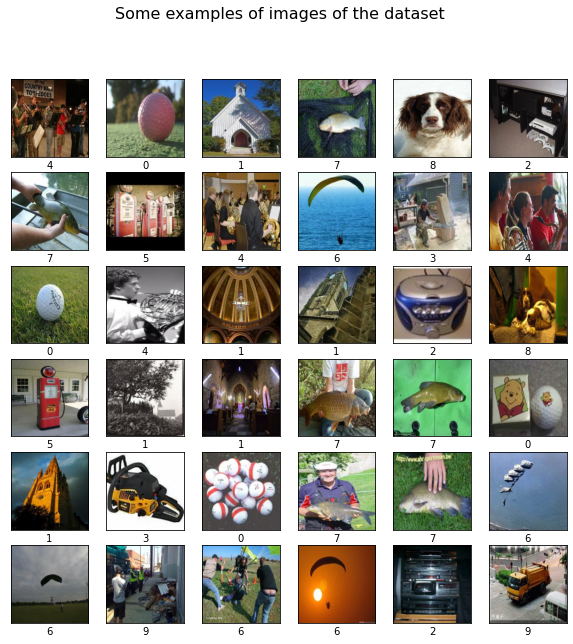

In [ ]:
display_examples(class_names, train_images, train_labels)

*Apply rotation and height shift augmentation (rotation_range, height_shift_range) to the dataset separately. Print theaugmented image and the original image for each class and each augmentation*

In [ ]:
data_generator = ImageDataGenerator(
        rotation_range=50,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255)

train_generator = data_generator.flow_from_directory(training_dir, target_size=im_shape, shuffle=True, seed=20,
                                                     class_mode='categorical', batch_size=60, subset="training")
nb_train_samples = train_generator.samples

Found 9509 images belonging to 10 classes.


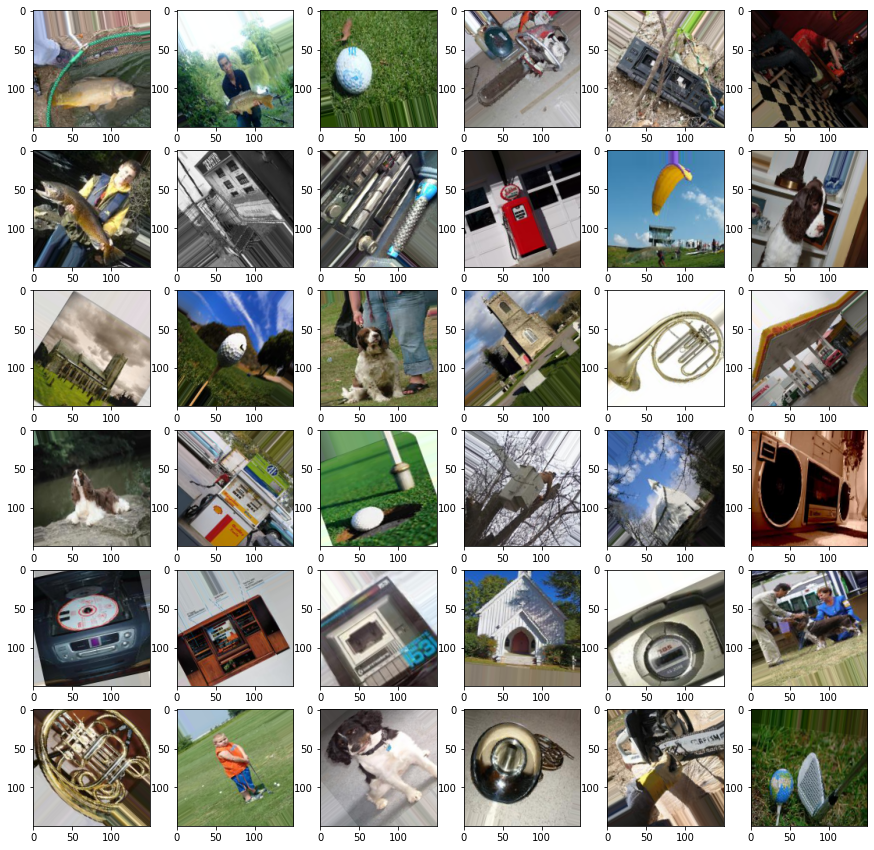

In [ ]:
# Visualizing some classes
plt.figure(figsize=(15,15))
for i in range(36):
    #gera subfigures
    plt.subplot(6,6,i+1)
   
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()


**3.Model Building**

*Sequential Model layers-Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons. Add L2 regularization to all the layers.*

- Hidden units choosen as 128, 100 since our input image size is 150,150 and the hiddent untis should be within the range of input and output size. 

*Add L2 regularization to all the layers*

*Add one layer of dropout at the appropriate position and give reasons*

- Added Droput layer after the hidden layer because they are the one with the greater number of parameters and thus they're likely to excessively co-adapting themselves causing overfitting

*Choose the appropriate activation function for all the layers.*

- We have used relu, in all the hidden layers because rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better.

*Print the model summary.*

In [ ]:
model = models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               22429824  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

**4. Model Compilation**

*Compile the model with the appropriate loss function.*

*Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.*

- We have used Adam, Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. This algorithm is used to accelerate the gradient descent algorithm by taking into consideration the 'exponentially weighted average' of the gradients. Using averages makes the algorithm converge towards the minima in a faster pace

*Use accuracy as a metric.*

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

**5. Model Training**

*Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.*

In [ ]:
train_images.shape

(9509, 150, 150, 3)

In [ ]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=25, validation_split = 0.2)

Epoch 1/25
60/60 [==============================] - 6s 87ms/step - loss: 18.2644 - accuracy: 0.1545 - val_loss: 6.3158 - val_accuracy: 0.2450
Epoch 2/25
60/60 [==============================] - 5s 78ms/step - loss: 5.6969 - accuracy: 0.2653 - val_loss: 4.3577 - val_accuracy: 0.2692
Epoch 3/25
60/60 [==============================] - 5s 78ms/step - loss: 4.0897 - accuracy: 0.2797 - val_loss: 3.4711 - val_accuracy: 0.2797
Epoch 4/25
60/60 [==============================] - 5s 79ms/step - loss: 3.3116 - accuracy: 0.3081 - val_loss: 3.0444 - val_accuracy: 0.2944
Epoch 5/25
60/60 [==============================] - 5s 78ms/step - loss: 2.9743 - accuracy: 0.3034 - val_loss: 2.7569 - val_accuracy: 0.3475
Epoch 6/25
60/60 [==============================] - 5s 79ms/step - loss: 2.7602 - accuracy: 0.3144 - val_loss: 2.7495 - val_accuracy: 0.2834
Epoch 7/25
60/60 [==============================] - 5s 78ms/step - loss: 2.6266 - accuracy: 0.2985 - val_loss: 2.5080 - val_accuracy: 0.3544
Epoch 8/25
6

*Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.*

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

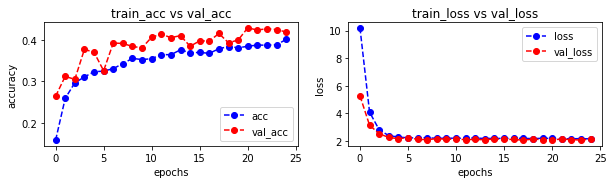

In [ ]:
plot_accuracy_loss(history)

**6. Model Evaluation**

*Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset.*

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

print(test_loss)

125/125 [==============================] - 1s 8ms/step - loss: 2.1427 - accuracy: 0.4118
[2.1427319049835205, 0.41182389855384827]


In [ ]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + str(labels[index]))
    plt.show()

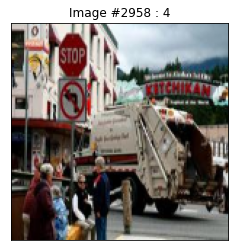

              precision    recall  f1-score   support

           0       0.37      0.44      0.40       409
           1       0.51      0.44      0.47       409
           2       0.63      0.42      0.50       357
           3       0.50      0.01      0.03       386
           4       0.51      0.48      0.49       404
           5       0.27      0.26      0.27       429
           6       0.84      0.37      0.51       400
           7       0.32      0.84      0.47       387
           8       0.30      0.40      0.34       395
           9       0.48      0.47      0.48       399

    accuracy                           0.41      3975
   macro avg       0.47      0.41      0.40      3975
weighted avg       0.47      0.41      0.40      3975

Time taken to predict the model 0.7911815643310547


In [ ]:
from sklearn.metrics import classification_report
import time

start_time = time.time()

predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels)

print(classification_report(test_labels, pred_labels))
print("Time taken to predict the model " + str(time.time() - start_time))

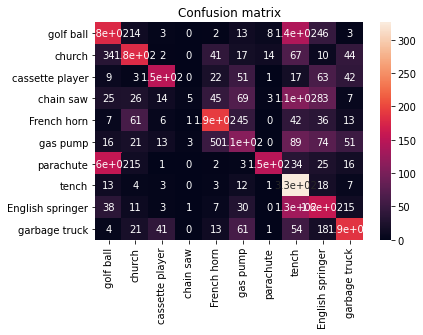

In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_label, 
           yticklabels=class_label, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

*Analyse and report the best and worst performing class.*

In [ ]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 20 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names, mislabeled_images, mislabeled_labels)

*Print the two most incorrectly classified images for each class in the test dataset.* *italicized text*

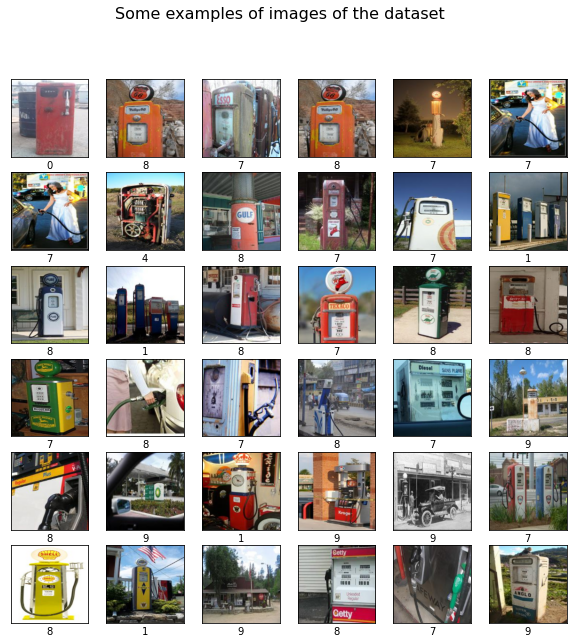

In [ ]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

**Hyperparameter Tuning**

**Modified Model 1**

*Network Depth: Change the number of hidden layers and hidden units for each layer*

In [ ]:
import gc
tf.keras.backend.clear_session()
gc.collect()

53954

In [ ]:
model = models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               4147300   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
 model.fit(train_images, train_labels, batch_size=64, epochs=25, validation_split = 0.2)

Epoch 1/25
119/119 [==============================] - 6s 47ms/step - loss: 0.4323 - accuracy: 0.8394 - val_loss: 1.5717 - val_accuracy: 0.6178
Epoch 2/25
119/119 [==============================] - 5s 43ms/step - loss: 0.4498 - accuracy: 0.8354 - val_loss: 1.5871 - val_accuracy: 0.6236
Epoch 3/25
119/119 [==============================] - 5s 44ms/step - loss: 0.4379 - accuracy: 0.8384 - val_loss: 1.7860 - val_accuracy: 0.6130
Epoch 4/25
119/119 [==============================] - 5s 43ms/step - loss: 0.4118 - accuracy: 0.8518 - val_loss: 1.7780 - val_accuracy: 0.6172
Epoch 5/25
119/119 [==============================] - 5s 43ms/step - loss: 0.3919 - accuracy: 0.8553 - val_loss: 1.7293 - val_accuracy: 0.5915
Epoch 6/25
119/119 [==============================] - 5s 43ms/step - loss: 0.3858 - accuracy: 0.8632 - val_loss: 1.6872 - val_accuracy: 0.6025
Epoch 7/25
119/119 [==============================] - 5s 44ms/step - loss: 0.3626 - accuracy: 0.8657 - val_loss: 1.7345 - val_accuracy: 0.6099

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

print(test_loss)

125/125 [==============================] - 1s 8ms/step - loss: 2.0252 - accuracy: 0.3696
[2.02522349357605, 0.36955973505973816]


**Modified model 2**

*Regularization: Train a model without regularization*

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

4138

In [ ]:
model = models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])



model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               5308544   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_labels, batch_size=128, epochs=25, validation_split = 0.2)

Epoch 1/25
60/60 [==============================] - 6s 94ms/step - loss: 2.6089 - accuracy: 0.1679 - val_loss: 1.8318 - val_accuracy: 0.3833
Epoch 2/25
60/60 [==============================] - 5s 84ms/step - loss: 1.7490 - accuracy: 0.4042 - val_loss: 1.5434 - val_accuracy: 0.5068
Epoch 3/25
60/60 [==============================] - 5s 84ms/step - loss: 1.4113 - accuracy: 0.5320 - val_loss: 1.3717 - val_accuracy: 0.5578
Epoch 4/25
60/60 [==============================] - 5s 85ms/step - loss: 1.1316 - accuracy: 0.6353 - val_loss: 1.2755 - val_accuracy: 0.5941
Epoch 5/25
60/60 [==============================] - 5s 84ms/step - loss: 0.8915 - accuracy: 0.7200 - val_loss: 1.3366 - val_accuracy: 0.5862
Epoch 6/25
60/60 [==============================] - 5s 84ms/step - loss: 0.7055 - accuracy: 0.7729 - val_loss: 1.4879 - val_accuracy: 0.5620
Epoch 7/25
60/60 [==============================] - 5s 83ms/step - loss: 0.5403 - accuracy: 0.8232 - val_loss: 1.4602 - val_accuracy: 0.5820
Epoch 8/25
60

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

print(test_loss)

125/125 [==============================] - 1s 8ms/step - loss: 2.7315 - accuracy: 0.5313
[2.7314999103546143, 0.5313207507133484]


**Comparing all the model**


- Base Model:

    Training set : 2.2455 - accuracy: 0.3604

    Test Set: 2.1427 - accuracy: 0.4118


- Model 1: 
    
    Training set : loss: 0.2593 - accuracy: 0.9011

    (loss is less and accuracy is less on training and more on test data. (so less overfitted model) 
    
    Test Set: loss: 2.0252 - accuracy: 0.3696


- Model 2:
    
    Training set : loss: 0.0510 - accuracy: 0.9839

    (loss is less and accuracy is more on training and more on test data. (so better model) 
    
    Test Set: loss: 2.7315 - accuracy: 0.5313